# Cluster the data 

In [76]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [77]:
adata = sc.read('/storage/users/data/PANC/H5AD_file/adata_filtered_no2D_hvg.h5ad')
#adata = sc.read('/storage/users/data/PANC/H5AD_file/adata_filtered_no2D_hvg_pub.h5ad')

In [78]:
adata

AnnData object with n_obs × n_vars = 6356 × 2000
    obs: 'condition', 'pct_cmo', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets', 'outlier', 'leiden'
    var: 'CMO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_symbol', 'ensembl_gene_id', 'mito', 'ribo', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'condition_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## Dimension reduction and Clustering

### Calculate DR & Clustering

In [79]:
# prepre clustering
#sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver="arpack") # PCA
sc.pp.neighbors(adata, n_neighbors=8, n_pcs=40) # Neighborhood Graph Construction

In [80]:
sc.tl.umap(adata)
sc.tl.leiden(adata)

### Visualize DR

In [81]:
!pwd

/storage/users/job37yv/Projects/PANC_cancer/code/scripts_beta


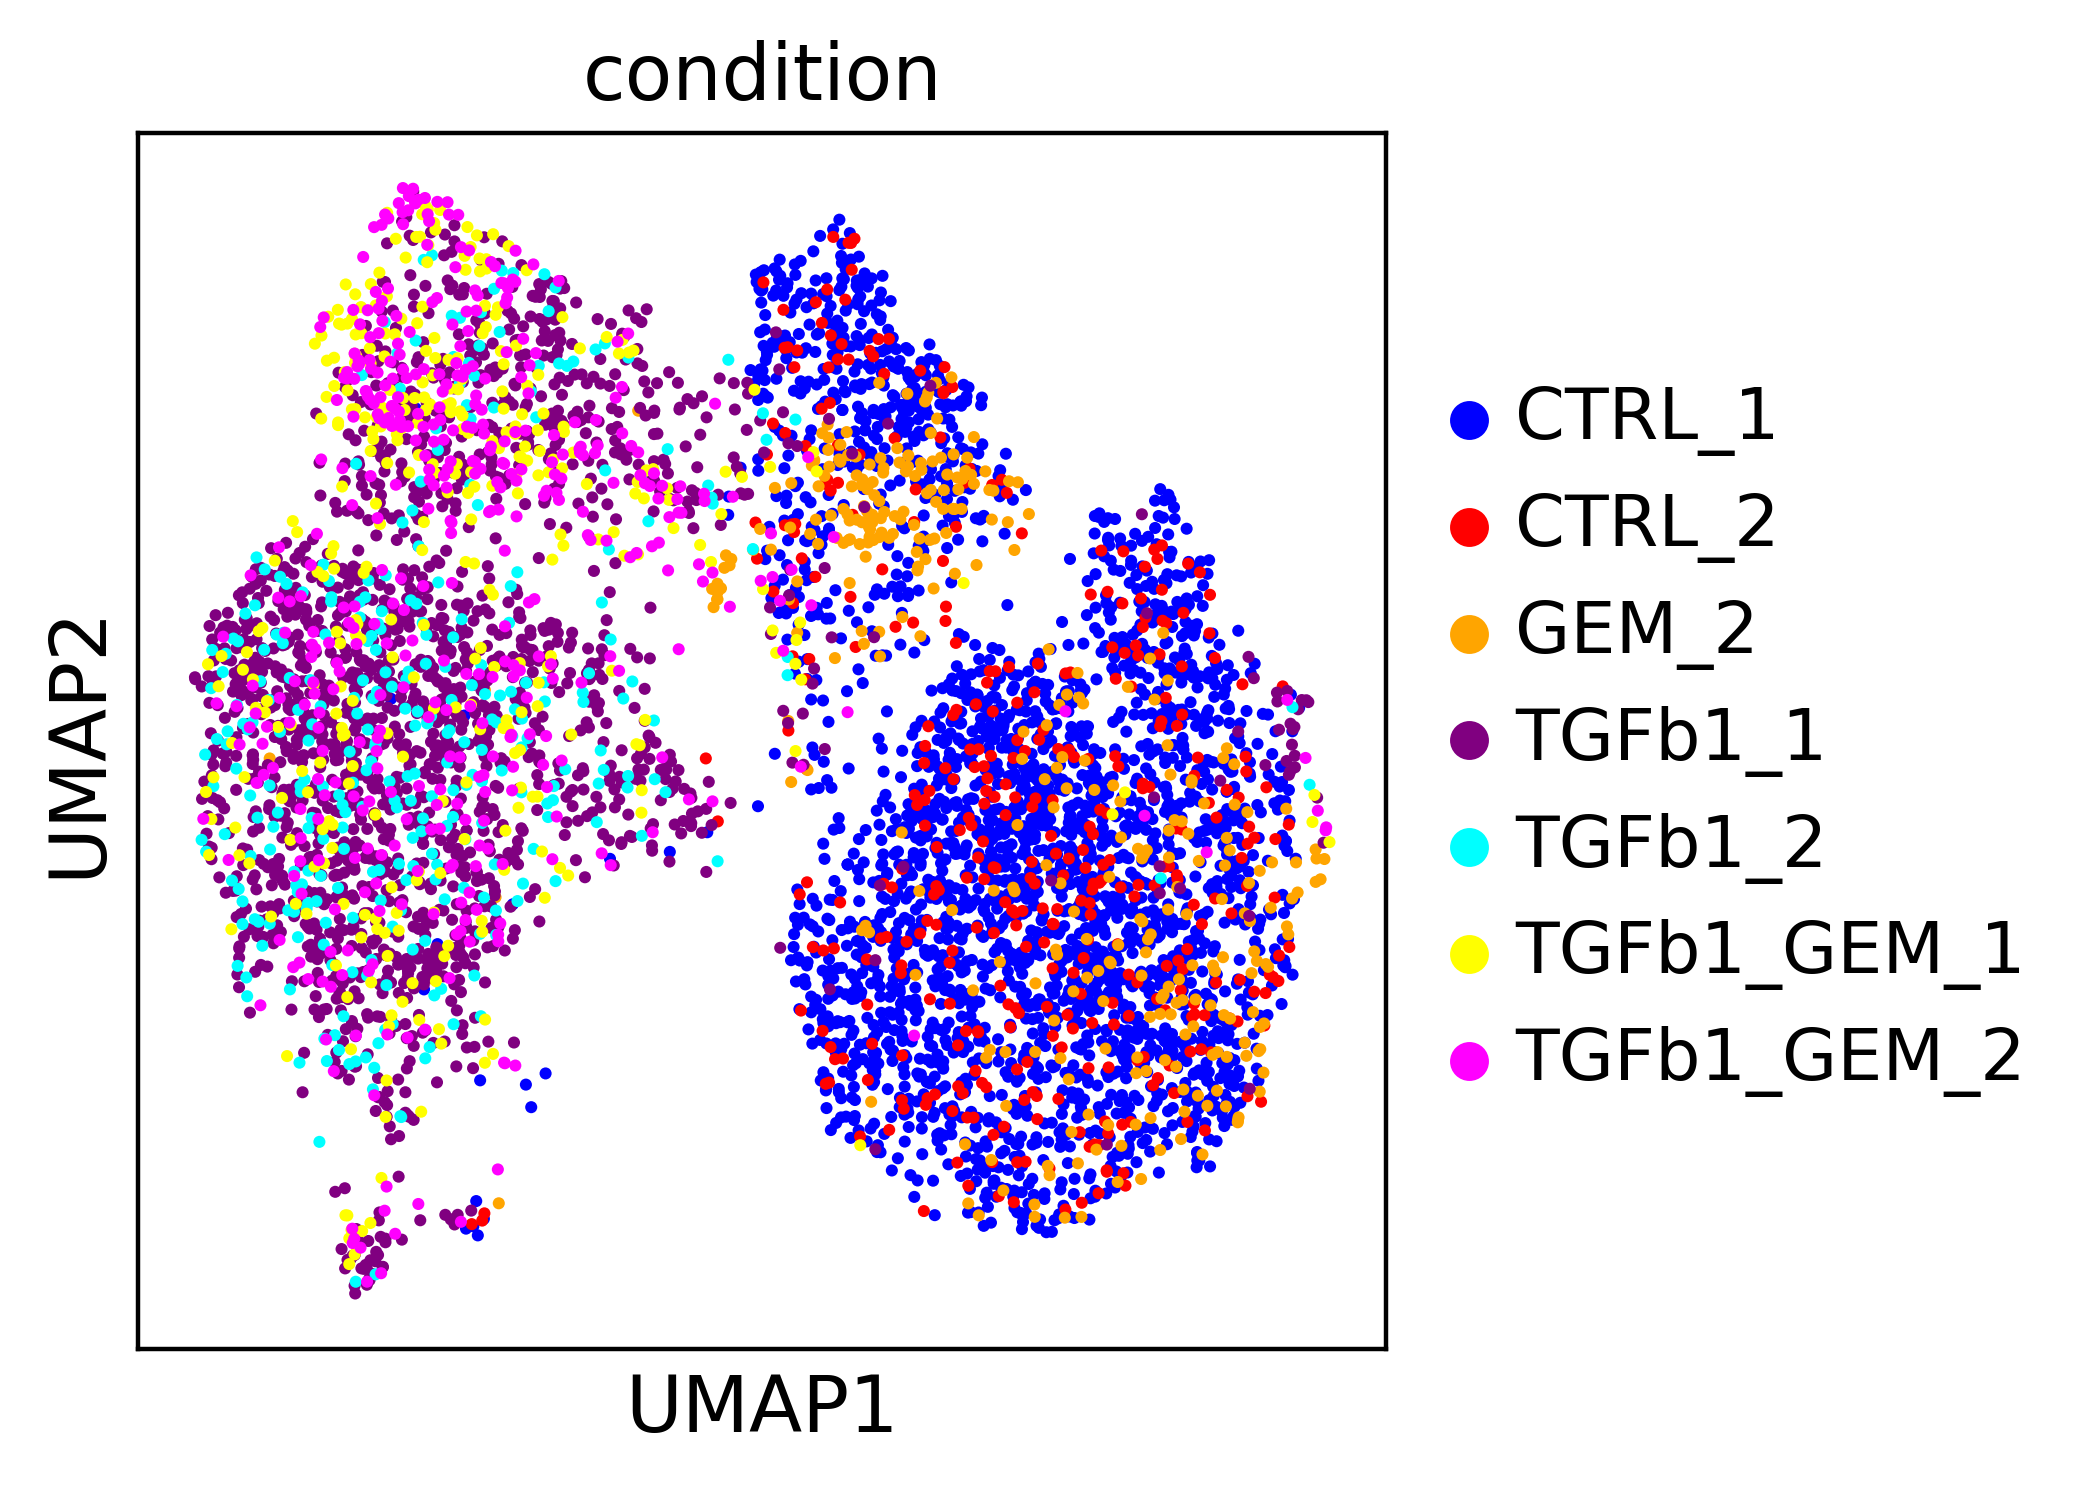

In [82]:
# Predefined condition-to-color mapping
condition_colors = {
    'CTRL_1': 'blue',
    'CTRL_2': 'red',
    'GEM_2': 'orange',
    'TGFb1_1': 'purple',
    'TGFb1_2': 'cyan',
    'TGFb1_GEM_1': 'yellow',
    'TGFb1_GEM_2': 'magenta'
}

# Ensure all conditions in adata.obs['condition'] have a color mapping
conditions = adata.obs['condition'].unique()
missing_conditions = set(conditions) - set(condition_colors.keys())
if missing_conditions:
    raise ValueError(f"Color mapping missing for conditions: {missing_conditions}")

# Plot the UMAP with the predefined colors
sc.settings.set_figure_params(dpi=200, dpi_save=300)
sc.pl.umap(
    adata,
    color=['condition'],
    legend_loc='right margin',
    palette=condition_colors,
    save="_UMAP_cond_preprocessing.png"
)

Found 5 clusters with resolution: 0.18


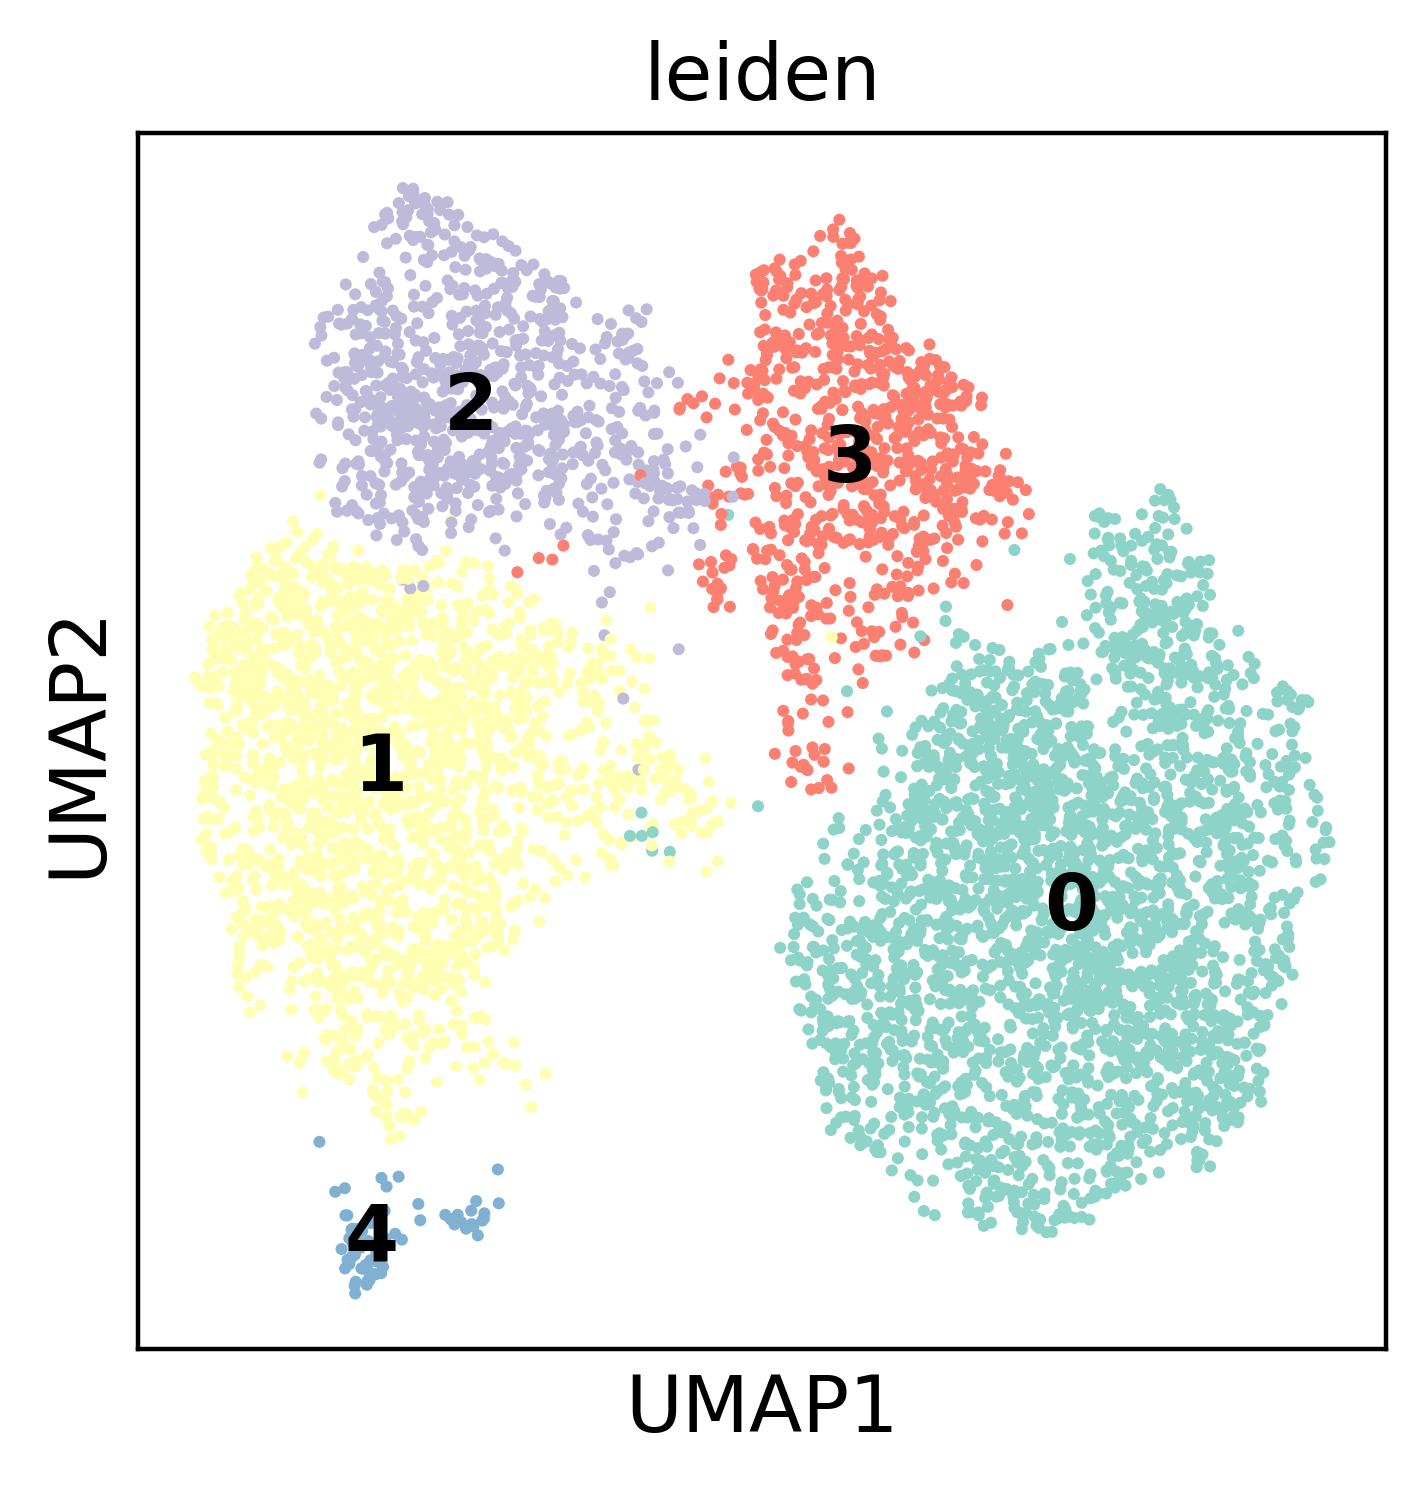

In [83]:
# Initialize variables
found = False
max_resolution = 1.0  # Maximum resolution to try
step_size = 0.01      # Step size for resolution
max_iterations = int(max_resolution / step_size)  # Calculate maximum iterations

# Iterate through Leiden resolutions to find 7 clusters
for i in range(max_iterations):
    resolution = step_size * (i + 1)  # Compute resolution
    sc.tl.leiden(adata, resolution=resolution)  # Perform Leiden clustering
    n_clusters = adata.obs['leiden'].nunique()  # Count unique clusters

    if n_clusters == 5:
        print(f"Found 5 clusters with resolution: {resolution}")
        found = True
        break  # Stop iteration once the desired number of clusters is found

# Stop condition handling
if not found:
    print(f"Could not find 5 clusters within resolution up to {max_resolution}.")
else:
    # Define a color palette for the clusters
    leiden_clusters = adata.obs['leiden']
    color_palette = sns.color_palette('Set3', n_clusters)

    # Visualize the UMAP with Leiden clustering
    sc.pl.umap(
        adata,
        color='leiden',
        palette=color_palette,
        legend_loc='on data',
        save=f"_UMAP_leiden_{resolution:.2f}_clusters.png"
    )

## Remove Outlier

In [84]:
adata_sub = adata[adata.obs["leiden"] != "4"].copy()

In [85]:
import numpy as np
from scipy.sparse import issparse

# Check if the matrix is sparse
if issparse(adata_sub.X):
    zero_count = adata_sub.X.size - adata_sub.X.nnz
else:
    zero_count = np.count_nonzero(adata_sub.X == 0)

total_elements = adata_sub.X.shape[0] * adata_sub.X.shape[1]
print(f"Total number of zeros: {zero_count}")
print(f"Percentage of zeros: {zero_count / total_elements * 100:.2f}%")

# Check for entirely zero rows or columns
if issparse(adata_sub.X):
    zero_rows = np.squeeze(np.array((adata_sub.X.sum(axis=1) == 0)))
    zero_cols = np.squeeze(np.array((adata_sub.X.sum(axis=0) == 0)))
else:
    zero_rows = np.all(adata_sub.X == 0, axis=1)
    zero_cols = np.all(adata_sub.X == 0, axis=0)

print("Number of completely zero rows: ", np.sum(zero_rows))
print("Number of completely zero columns: ", np.sum(zero_cols))

Total number of zeros: 0
Percentage of zeros: 0.00%
Number of completely zero rows:  0
Number of completely zero columns:  8


In [86]:
# Optionally, filter out zero rows and columns
if np.sum(zero_rows) > 0:
    adata_sub = adata_sub[~zero_rows, :]
if np.sum(zero_cols) > 0:
    adata_sub = adata_sub[:, ~zero_cols]

In [87]:
print(adata.shape)

(6356, 2000)


In [88]:
print(adata_sub.shape)

(6281, 1992)


### Recomputing Metrics and Dimensionality Reduction After Data Filtering in Scanpy

In [89]:
# 2. Revert to raw counts in .X (assuming adata.raw stores unlogged counts).
#adata_sub.X = np.expm1(adata_sub.X)

# 3. Now re-run normalization from scratch:
#sc.pp.normalize_total(adata_sub, target_sum=1e4)

# 4. Log-transform (now that .X holds library-size normalized counts)
#sc.pp.log1p(adata_sub)


# Scale the data
#sc.pp.scale(adata_sub, max_value=10)

# Calculate PCA
sc.tl.pca(adata_sub)

# Compute neighbors
sc.pp.neighbors(adata_sub)

# Compute UMAP (Optional)
sc.tl.umap(adata_sub)

/home/job37yv/miniforge3/envs/scAnalysis/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


### Recalcualte leiden

Found 5 clusters with resolution: 0.16


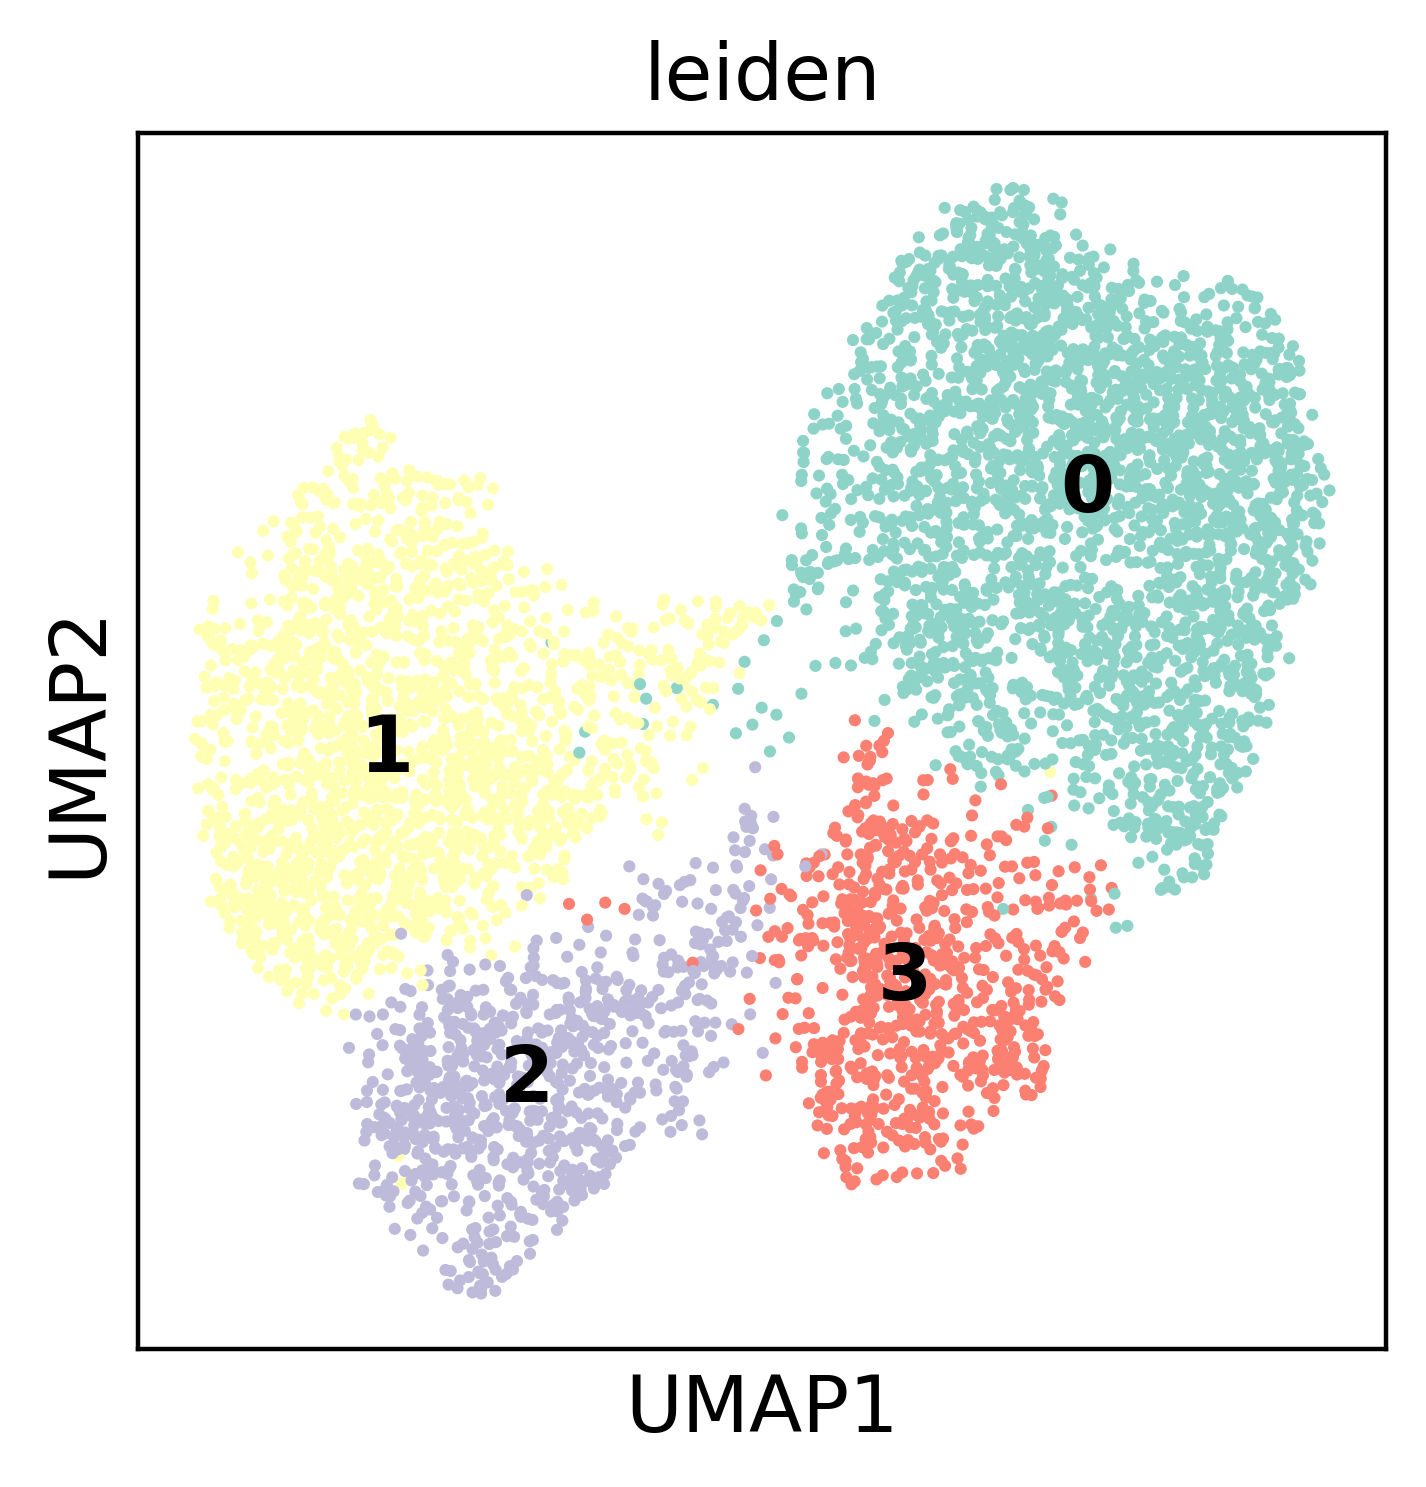

In [90]:
# Initialize variables
found = False
max_resolution = 1.0  # Maximum resolution to try
step_size = 0.01      # Step size for resolution
max_iterations = int(max_resolution / step_size)  # Calculate maximum iterations

# Iterate through Leiden resolutions to find 7 clusters
for i in range(max_iterations):
    resolution = step_size * (i + 1)  # Compute resolution
    sc.tl.leiden(adata_sub, resolution=resolution)  # Perform Leiden clustering
    n_clusters = adata_sub.obs['leiden'].nunique()  # Count unique clusters

    if n_clusters == 4:
        print(f"Found 5 clusters with resolution: {resolution}")
        found = True
        break  # Stop iteration once the desired number of clusters is found

# Stop condition handling
if not found:
    print(f"Could not find 5 clusters within resolution up to {max_resolution}.")
else:
    # Define a color palette for the clusters
    leiden_clusters = adata_sub.obs['leiden']
    color_palette = sns.color_palette('Set3', n_clusters)

    # Visualize the UMAP with Leiden clustering
    sc.pl.umap(
        adata_sub,
        color='leiden',
        palette=color_palette,
        legend_loc='on data',
        save=f"_UMAP_leiden_{resolution:.2f}_clusters.png"
    )

## Export

In [91]:
adata_sub.write("/storage/users/data/PANC/H5AD_file/adata_filtered_no2D_hvg_clust.h5ad")